<a href="https://colab.research.google.com/github/ferbator/data-engineering/blob/main/M33071_%D0%9A%D0%B0%D1%80%D0%B5%D0%BF%D0%B8%D0%BD_%22lab6_1%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение нейрона с помощью функции потерь LogLoss

<h3 style="text-align: center;"><b>Нейрон с сигмоидой</b></h3>

Снова рассмотрим нейрон с сигмоидой, то есть $$f(x) = \sigma(x)=\frac{1}{1+e^{-x}}$$ 

Ранее мы установили, что **обучение нейрона с сигмоидой с квадратичной функцией потерь**:  

$$MSE(w, x) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (\sigma(w \cdot x_i) - y_i)^2$$    

где $w \cdot x_i$ - скалярное произведение, а $\sigma(w \cdot x_i) =\frac{1}{1+e^{-w \cdot x_i}} $ - сигмоида -- **неэффективно**, то есть мы увидели, что даже за большое количество итераций нейрон предсказывает плохо.

Давайте ещё раз взглянем на формулу для градиентного спуска от функции потерь $MSE$ по весам нейрона:

$$ \frac{\partial MSE}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

А теперь смотрим на график сигмоиды:

<img src="https://cdn-images-1.medium.com/max/1200/1*IDAnCFoeXqWL7F4u9MJMtA.png" width=500px height=350px>

**Её значения: числа от 0 до 1.**

Если получше проанализировать формулу, то теперь можно заметить, что, поскольку сигмоида принимает значения между 0 и 1 (а значит (1-$\sigma$) тоже принимает значения от 0 до 1), то мы умножаем $X^T$ на столбец $(\sigma(w \cdot X) - y)$ из чисел от -1 до 1, а потом ещё на столбцы $\sigma(w \cdot X)$ и $(1 - \sigma(w \cdot X))$ из чисел от 0 до 1. Таким образом в лучшем случае $\frac{\partial{Loss}}{\partial{w}}$ будет столбцом из чисел, порядок которых максимум 0.01 (в среднем, понятно, что если сигмоида выдаёт все 0, то будет 0, если все 1, то тоже 0). После этого мы умножаем на шаг градиентного спуска, который обычно порядка 0.001 или 0.1 максимум. То есть мы вычитаем из весов числа порядка ~0.0001. Медленновато спускаемся, не правда ли? Это называют **проблемой затухающих градиентов**.

Чтобы избежать эту проблему в задачах классификации, в которых моделью является нейрон с сигмоидной функцией активации, предсказывающий "вероятности" принадлженостей к классам используют **LogLoss**:  

$$J(\hat{y}, y) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) = -\frac{1}{n} \sum_{i=1}^n y_i \log(\sigma(w \cdot x_i)) + (1 - y_i) \log(1 - \sigma(w \cdot x_i))$$

где, как и прежде, $y$ - столбец $(n, 1)$ из истинных значений классов, а $\hat{y}$ - столбец $(n, 1)$ из предсказаний нейрона.

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [ ]:
def loss(y_pred, y):
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

Отметим, что сейчас речь идёт именно о **бинарной классификации (на два класса)**, в многоклассовой классификации используется функция потерь под названием *кросс-энтропия*, которая является обобщением LogLoss'а на случай нескольких классов.

Почему же теперь всё будет лучше? Раньше была проблема умножения маленьких чисел в градиенте. Давайте посмотрим, что теперь:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
-\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)(\sigma(w \cdot x_i))_{w_j}' = -\frac{1}{n} \sum_{i=1}^n \left(\frac{y_i}{\sigma(w \cdot x_i)} - \frac{1 - y_i}{1 - \sigma(w \cdot x_i)}\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij} = $$
$$-\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{ij}$$

* Градиент $Loss$'а по вектору весов -- это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$ (помним, что весов всего $m$):

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i1} \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{i2} \\
           \vdots \\
           -\frac{1}{n} \sum_{i=1}^n \left(y_i - \sigma(w \cdot x_i)\right)x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T \left(\hat{y} - y\right)$$

По аналогии с $w_j$ выведите формулу для свободного члена (bias'а) $b$ (*hint*: можно считать, что при нём есть признак $x_{i0}=1$ на всех $i$).

Получили новое правило для обновления $w$ и $b$. 

In [ ]:
def sigmoid(x):
    """Сигмоидальная функция"""
    return 1 / (1 + np.exp(-x))

Реализуйте нейрон с функцией потерь LogLoss:

In [ ]:
class Neuron:
    
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        # пока что мы не знаем размер матрицы X, а значит не знаем, сколько будет весов
        self.w = w
        self.b = b
        
        
    def activate(self, x):
        return sigmoid(x)
    
        
    def forward_pass(self, X):
        """"
        Рассчитывает ответ нейрон при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрон 
        """
        n = X.shape[0]
        y_pred = np.zeros((n, 1))  # y_pred == y_predicted - предсказанные классы
        y_pred = self.activate(X @ self.w.reshape(X.shape[1], 1) + self.b)
        return y_pred.reshape(-1, 1)
    
    def backward_pass(self, X, y, y_pred, learning_rate=0.1):
        """
        Обновляет значения весов нейрона в соответствие с этим объектом
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        # тут нужно обновить веса по формулам, написанным выше
        n = len(y)
        y = np.array(y).reshape(-1, 1)
        sigma = self.activate(X @ self.w + self.b)
        self.w = self.w - learning_rate * (X.T @ (sigma - y)) / n
        self.b = self.b - learning_rate * np.mean(sigma - y) 
    
    def fit(self, X, y, num_epochs=5000):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: J_values -- вектор значений функции потерь
        """
        if self.w is None:
          self.w = np.zeros((X.shape[1], 1))  # столбец (m, 1)
          self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            # предсказания с текущими весами
            y_pred = self.forward_pass(X)
            # считаем функцию потерь с текущими весами
            loss_values.append(loss(y_pred, y))
            # обновляем веса по формуле градиентного спуска
            self.backward_pass(X, y, y_pred)

        return loss_values

<h3 style="text-align: center;"><b>Тестирование</b></h3>

Протестируем нейрон, обученный с новой функцией потерь, на тех же данных, что и в предыдущем ноутбуке:

**Проверка forward_pass()**

In [ ]:
w = np.array([1., 2.]).reshape(2, 1)
b = 2.
X = np.array([[1., 3.],
              [2., 4.],
              [-1., -3.2]])

neuron = Neuron(w, b)
y_pred = neuron.forward_pass(X)
print ("y_pred = " + str(y_pred))

y_pred = [[0.99987661]
 [0.99999386]
 [0.00449627]]


**Проверка backward_pass()**

In [ ]:
y = np.array([1, 0, 1]).reshape(3, 1)

In [ ]:
neuron.backward_pass(X, y, y_pred)

print ("w = " + str(neuron.w))
print ("b = " + str(neuron.b))

w = [[0.9001544 ]
 [1.76049276]]
b = 1.9998544421863216


Проверьте на наборах данных "яблоки и груши" и "голос".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("drive/MyDrive/ML/data/apples_pears.csv")
data.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


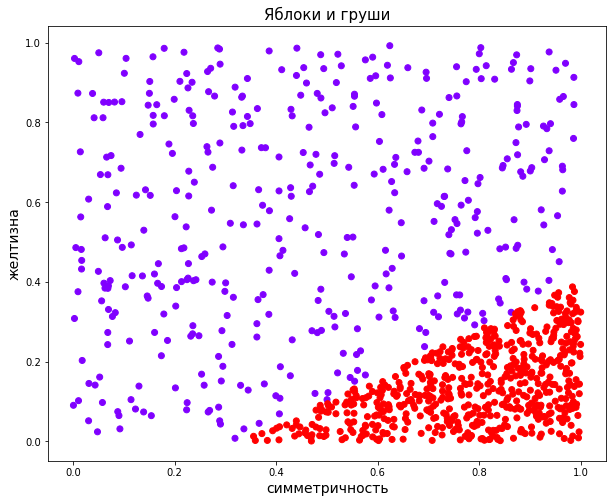

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [ ]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
neuron = Neuron()
Loss_values = neuron.fit(X_train, y_train, num_epochs=10000)

pred = neuron.forward_pass(X_test)
y_pred = [1 if pred[i] > 0.5 else 0 for i in range(len(pred))]
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        91
           1       1.00      0.95      0.97       159

    accuracy                           0.97       250
   macro avg       0.96      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



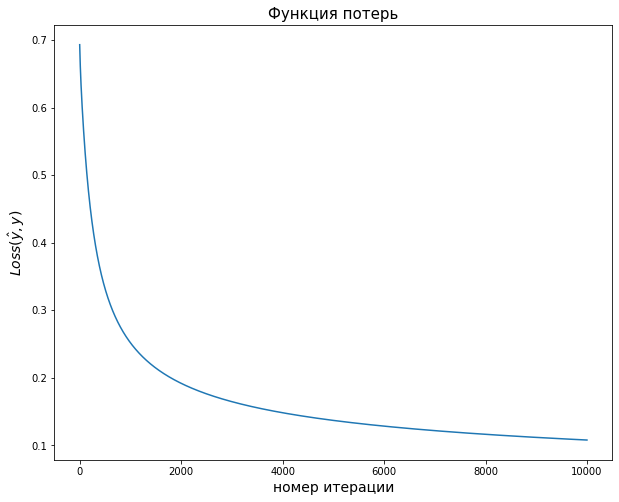

In [ ]:
neuron = Neuron()
Loss_values = neuron.fit(X, y,num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

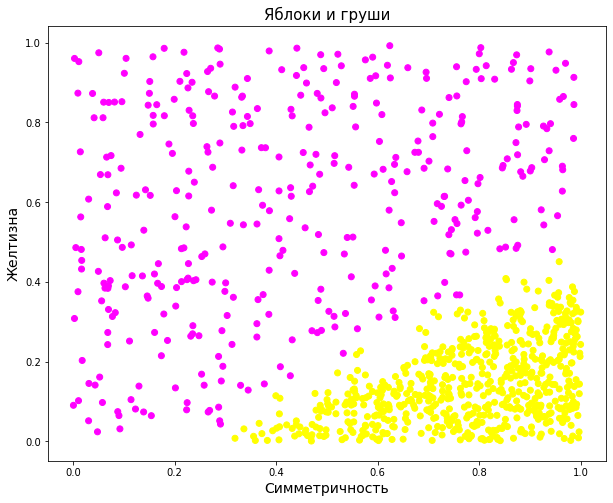

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=np.array(neuron.forward_pass(X) > 0.5).ravel(), cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('Симметричность', fontsize=14)
plt.ylabel('Желтизна', fontsize=14)
plt.show();

In [ ]:
data = pd.read_csv("drive/MyDrive/ML/data/voice.csv")
data['label'] = data['label'].apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
data = data.sample(frac=1)
X_train = data.iloc[:int(len(data)*0.7), :-1]  # матрица объекты-признаки
y_train = data.iloc[:int(len(data)*0.7), -1]  # истинные значения пола (мужчина/женщина)

X_test = data.iloc[int(len(data)*0.7):, :-1]  # матрица объекты-признаки
y_test = data.iloc[int(len(data)*0.7):, -1] 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler()

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

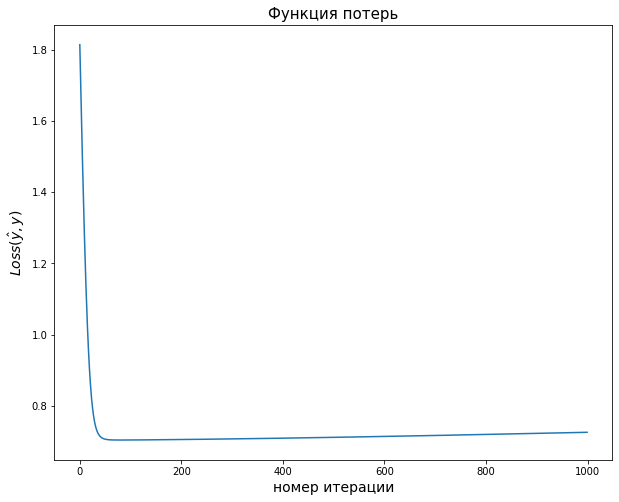

In [ ]:
neuron = Neuron(w=np.random.rand(X_train.shape[1], 1), b=np.random.rand(1))
Loss_values = neuron.fit(X_train, y_train.values, num_epochs=10000)

plt.figure(figsize=(10, 8))
plt.plot(Loss_values)
plt.title('Функция потерь', fontsize=15)
plt.xlabel('номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

pred = neuron.forward_pass(X_test)
y_pred = [1 if pred[i] > 0.5 else 0 for i in range(len(pred))]
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       519
           1       0.75      0.83      0.79       432

    accuracy                           0.80       951
   macro avg       0.80      0.80      0.80       951
weighted avg       0.80      0.80      0.80       951

